# LeNet-5 (1998, Yan LeCunn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Activation

from tensorflow.keras.datasets import mnist
np.random.seed(101)

### train, test split

In [2]:
# 자동으로 파이썬의 튜플 형태로 데이터가 나눠짐
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


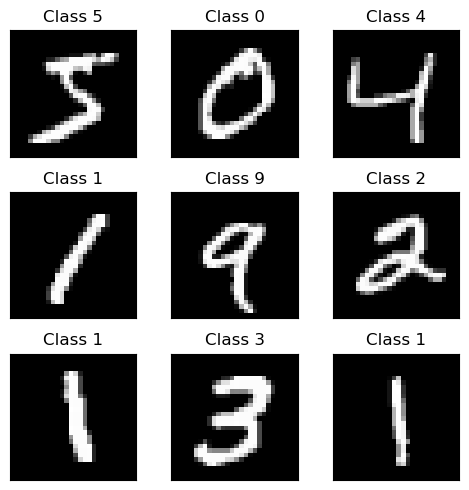

In [3]:
# 클래스 별 그림
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none') # default : color
    plt.title("Class {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### scaling 
- 0 `~` 1 사이로 pixel 값을 scale

In [4]:
# simple scailing : 최대값으로 나눠 0 ~ 1 사이로 pixel 값을 scale
X_train_scaled = X_train / 255.
X_test_scaled = X_test / 255.
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28), (10000, 28, 28))

### Conv2D layer 의  입력 사양에 맞추어 3 dimension 으로 차원 증가

In [5]:
# Conv2D layer 의 입력 사양에 맞추어 3 dimension 으로 차원 증가 : 흑백이므로 1 (컬러면 3)
X_train_scaled = np.expand_dims(X_train_scaled, axis=3)
X_test_scaled = np.expand_dims(X_test_scaled, axis=3)
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### label 을 one-hot-encoding

In [6]:
# 레이블을 one hot encoding 해줌 -> categorical cross entryopy를 적용하기 위함
# (60000, 10) (10000, 10)
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

## tf.data 를 이용한 shuffling and batch 구성

In [7]:
# tf.data 를 이용한 shuffling and batch 구성
# gpu에 효율적으로 데이터를 올리기 위해 사용 (안해도 나중에 변환과정을 거쳐짐
# 이거 하기 전은 numpy 데이터 (GPU에서는 못돌아가는 데이터 타입)
# 그냥 출력하면 뭐가 나오지 않음
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_onehot)).shuffle(10000).batch(128) # 튜플 형태로 입력피처, 레이블 데이터를 넣음 
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot)).batch(128) # shuffle 필요 없음 -> test에 굳이,,,,!


## LeNet 구성

<img src="https://d2l.ai/_images/lenet.svg" width="800" />

In [9]:
model = tf.keras.Sequential()

model.add(Conv2D(6, kernel_size=5, padding="same", input_shape=(28, 28, 1))) # 패딩 적용
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(16, kernel_size=5, padding="valid"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(120))
model.add(Activation ('relu'))

model.add(Dense(84))
model.add(Activation ('relu'))

model.add(Dense(10))
model.add(Activation ('softmax')) # 다중분류이므로 softmax

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                    

In [11]:
model.compile(loss="categorical_crossentropy", 
              optimizer='adam', metrics=['accuracy'])

In [12]:
history = model.fit(train_ds, epochs=5, 
                    validation_data=test_ds)

Epoch 1/5
469/469 [==============================] - 64s 128ms/step - loss: 0.3005 - accuracy: 0.9122 - val_loss: 0.0839 - val_accuracy: 0.9745
Epoch 2/5
469/469 [==============================] - 56s 120ms/step - loss: 0.0810 - accuracy: 0.9747 - val_loss: 0.0655 - val_accuracy: 0.9796
Epoch 3/5
469/469 [==============================] - 35s 74ms/step - loss: 0.0604 - accuracy: 0.9815 - val_loss: 0.0435 - val_accuracy: 0.9861
Epoch 4/5
469/469 [==============================] - 36s 76ms/step - loss: 0.0482 - accuracy: 0.9849 - val_loss: 0.0365 - val_accuracy: 0.9889
Epoch 5/5
469/469 [==============================] - 36s 76ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0360 - val_accuracy: 0.9889


In [13]:
score = model.evaluate(test_ds, verbose=0)

In [14]:
print("Test Score ", score[0])
print("Test Accuracy ", score[1])

Test Score  0.03604069724678993
Test Accuracy  0.9889000058174133


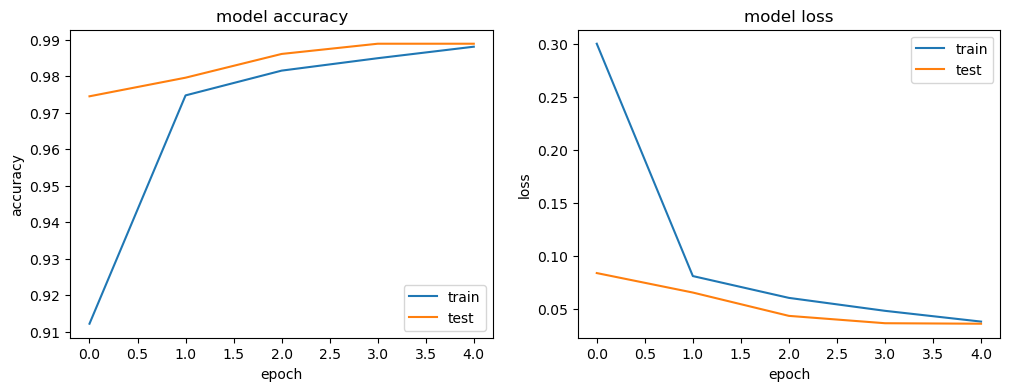

In [15]:
# 모델 훈련 결과 시각화 : 과적합이 일어났는지 확인하기 위함
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

In [16]:
y_pred = model.predict(X_test_scaled).argmax(axis=1)
y_pred

313/313 [==============================] - 3s 10ms/step


array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

[[ 973    0    1    0    0    0    2    2    2    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   0    3 1024    1    1    0    0    3    0    0]
 [   0    0    6  993    1    1    0    5    4    0]
 [   0    0    1    0  980    0    0    0    0    1]
 [   2    0    1    4    0  882    2    1    0    0]
 [   4    4    0    0    1    4  944    0    1    0]
 [   0    4    5    0    0    0    0 1018    0    1]
 [   1    0    2    0    0    2    1    1  965    2]
 [   0    4    2    1   17    1    0    6    1  977]]
Test Accuracy : 0.9889


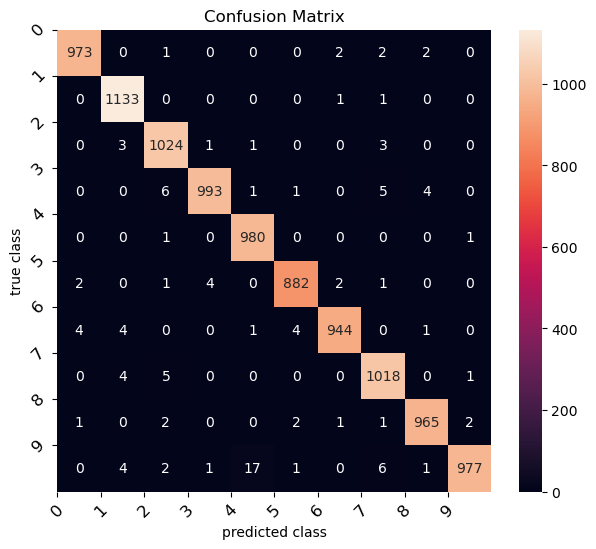

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(7,6))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

plt.xticks(np.arange(10), list(range(10)), rotation=45, fontsize=12)
plt.yticks(np.arange(10), list(range(10)), rotation=45, fontsize=12)
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.title('Confusion Matrix')
print('Test Accuracy :', accuracy_score(y_test, y_pred))

# 실습 : fashion MNIST 를 이용하여 위와 동일한 작업

Label	Class  
0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation

np.random.seed(102)

In [22]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

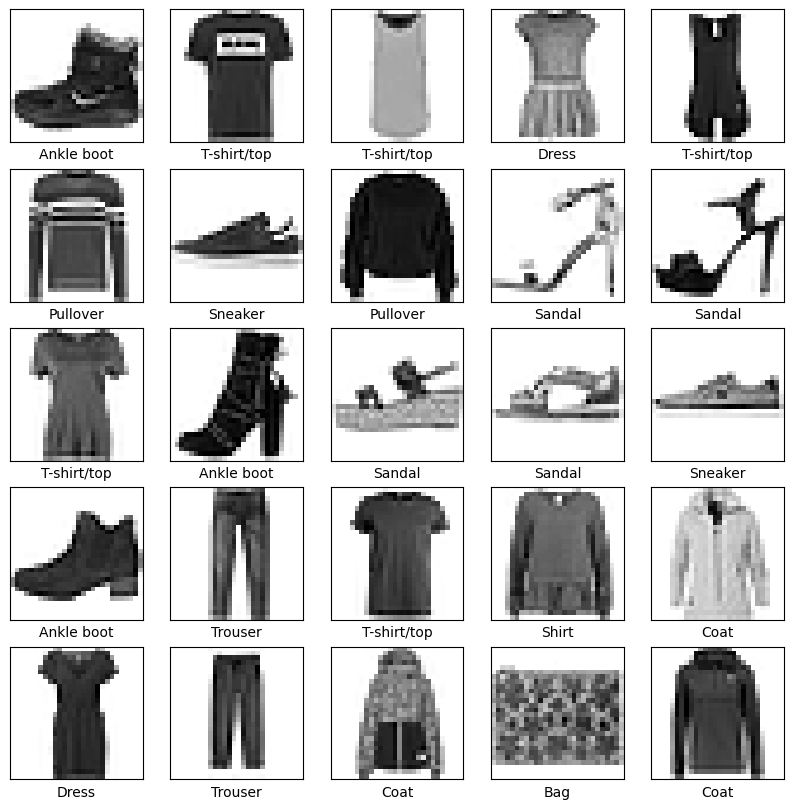

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
    plt.xticks([])
    plt.yticks([])

In [25]:
X_train = train_images / 255.0
X_test  = test_images / 255.0

In [26]:
# Conv2D layer 의 입력 사양에 맞추어 3 dimension 으로 차원 증가
X_train_scaled = np.expand_dims(X_train_scaled, axis=3)
X_test_scaled = np.expand_dims(X_test_scaled, axis=3)
X_train_scaled.shape, X_test_scaled.shape # ((60000, 28, 28, 1), (10000, 28, 28, 1))


((60000, 28, 28, 1, 1), (10000, 28, 28, 1, 1))

In [27]:
# 레이블을 one hot encoding : (60000, 10) (10000, 10)
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

In [28]:
# tf.data 를 이용한 shuffling and batch 구성
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_onehot)).shuffle(10000).batch(128) # 튜플 형태로 입력피처, 레이블 데이터를 넣음 
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot)).batch(128) # shuffle 필요 없음 -> test에 굳이,,,,!


In [29]:
# LeNet model 구성
# kernel 사이즈를 줄이고 convolution 층 한번 더 늘림
model = tf.keras.Sequential()

model.add(Conv2D(6, kernel_size=3, padding="same", input_shape=(28, 28, 1))) # 패딩 적용
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(16, kernel_size=3, padding="valid"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(32, kernel_size=3, padding="valid"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(120))
model.add(Activation ('relu'))

model.add(Dense(84))
model.add(Activation ('relu'))

model.add(Dense(10))
model.add(Activation ('softmax')) # 다중분류이므로 softmax

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 activation_5 (Activation)   (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        880       
                                                                 
 activation_6 (Activation)   (None, 12, 12, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                  

In [32]:

# model compile 
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [33]:
# 모델 학습
history = model.fit(train_ds, epochs=5, validation_data=test_ds)
                    
score = model.evaluate(test_ds, verbose=0)
print("Test loss ", score[0]) # Test loss 
print("Test Accuracy ", score[1]) # Test Accuracy

y_pred = model.predict(X_test_scaled).argmax(axis=1)

Epoch 1/5
469/469 [==============================] - 58s 105ms/step - loss: 0.3733 - accuracy: 0.8922 - val_loss: 0.1265 - val_accuracy: 0.9598
Epoch 2/5
469/469 [==============================] - 31s 65ms/step - loss: 0.1020 - accuracy: 0.9678 - val_loss: 0.0718 - val_accuracy: 0.9765
Epoch 3/5
469/469 [==============================] - 27s 57ms/step - loss: 0.0726 - accuracy: 0.9777 - val_loss: 0.0534 - val_accuracy: 0.9825
Epoch 4/5
469/469 [==============================] - 33s 70ms/step - loss: 0.0586 - accuracy: 0.9818 - val_loss: 0.0509 - val_accuracy: 0.9831
Epoch 5/5
469/469 [==============================] - 31s 67ms/step - loss: 0.0508 - accuracy: 0.9840 - val_loss: 0.0487 - val_accuracy: 0.9838
Test loss  0.04873352497816086
Test Accuracy  0.9837999939918518
313/313 [==============================] - 3s 8ms/step


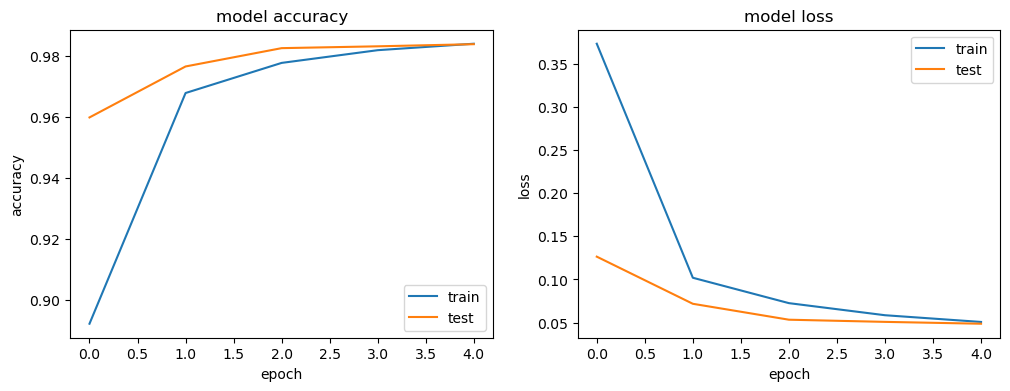

In [34]:
# 모델 훈련 결과 시각화
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

Text(50.722222222222214, 0.5, 'true class')

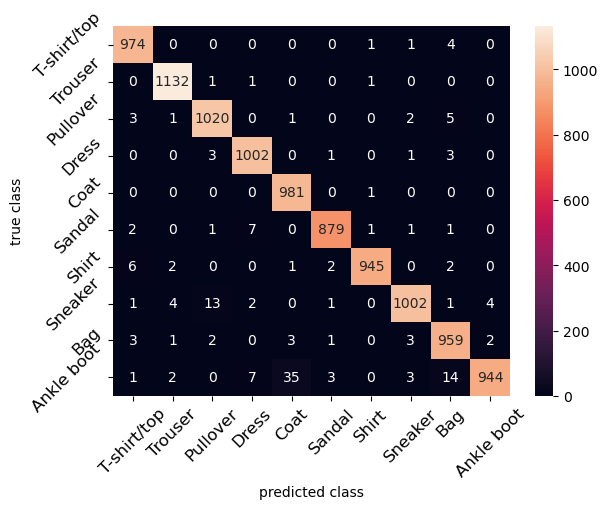

<Figure size 700x600 with 0 Axes>

In [35]:
# confusion matrix 시각화
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')
plt.figure(figsize=(7,6))
ax.set_xticklabels(class_names,  rotation=45, fontsize=12)
ax.set_yticklabels(class_names,  rotation=45, fontsize=12)
ax.set_xlabel("predicted class")
ax.set_ylabel("true class")

# CIFAR-10 을 이용한 CNN 구축

In [36]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [37]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 73s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [38]:
# 클래스별 이름
cifa10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


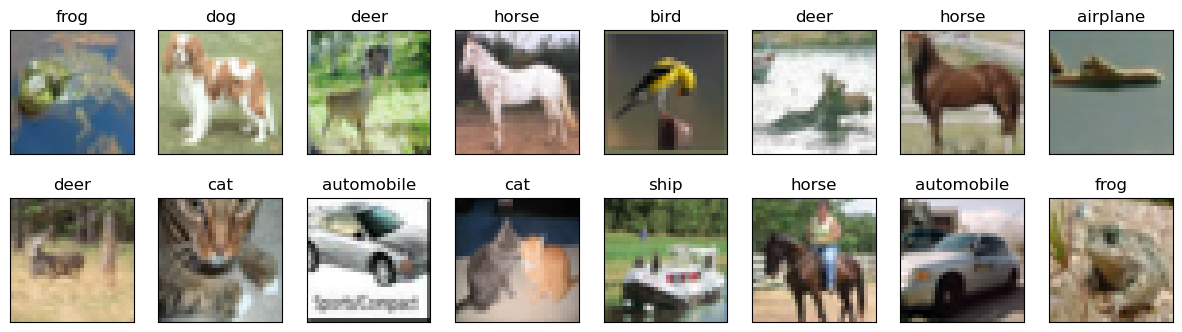

In [39]:
# 클래스별 사진 시각화
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
axes = axes.ravel()
for i in range(16):
    idx = np.random.randint(0, len(y_train))
    axes[i].imshow(X_train[idx, :])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(cifa10_classes[y_train[idx, 0]])

In [40]:
# data normalization
X_train_scaled = X_train / 255.
X_test_scaled  = X_test / 255.

In [41]:
# one-hot encoding of class labels
# categorical cross entryopy를 적용하기 위함
y_train_onehot = utils.to_categorical(y_train)
y_test_onehot  = utils.to_categorical(y_test)
print(y_train_onehot.shape)
print(y_test_onehot.shape)

(50000, 10)
(10000, 10)


In [42]:
# tf.data 를 이용한 shuffling and batch 구성
# gpu에 효율적으로 데이터를 올리기 위해 사용 (안해도 나중에 변환과정을 거쳐짐
# 이거 하기 전은 numpy 데이터 (GPU에서는 못돌아가는 데이터 타입)
# 그냥 출력하면 뭐가 나오지 않음
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_onehot)).shuffle(10000).batch(64)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot)).batch(64)

In [43]:
# model build
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) # strides 지정이 생략됨 => pool 사이즈와 동일하게
model.add(Dropout(0.2)) # 20 % 뉴런 deactivate

# 앞 보다 필터 사이즈 늘려감-> 계속 늘려감 -> 사진 사이지는 maxpooling 되며 작아지지만, 개수는 늘어나도록
model.add(Conv2D(32, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten()) # Dense 레이어와 연결하기 위해
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 아웃풋 레이어와 바로 열결 / 다중분류여서 softmax

# 모델 요약
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 activation_11 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 activation_12 (Activation)  (None, 16, 16, 32)        0         
                                                      

In [44]:
# model compile : 다중분류여서 categorical_crossentropy
# Adam을 함수로 부르게 되면 파라미터로 학습률등을 지정 가능
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [62]:
# 모델 학습
history = model.fit(train_ds, epochs=5, validation_data=test_ds, verbose=1, shuffle=True)

Epoch 1/5


782/782 [==============================] - 94s 120ms/step - loss: 1.0362 - accuracy: 0.6331 - val_loss: 0.9019 - val_accuracy: 0.6828
Epoch 2/5
782/782 [==============================] - 91s 116ms/step - loss: 1.0021 - accuracy: 0.6477 - val_loss: 0.9196 - val_accuracy: 0.6767
Epoch 3/5
782/782 [==============================] - 111s 142ms/step - loss: 0.9745 - accuracy: 0.6532 - val_loss: 0.8783 - val_accuracy: 0.6933
Epoch 4/5
782/782 [==============================] - 124s 159ms/step - loss: 0.9471 - accuracy: 0.6669 - val_loss: 0.8293 - val_accuracy: 0.7121
Epoch 5/5
782/782 [==============================] - 131s 167ms/step - loss: 0.9248 - accuracy: 0.6720 - val_loss: 0.8220 - val_accuracy: 0.7155


In [63]:
model.evaluate(test_ds, verbose=0)

[0.8219630718231201, 0.715499997138977]

In [64]:
# 확률 분포를 반환하므로 argmax를 이용해, 가장 확률이 높은 인덱스값 반환하도록
# => y_test와 비교할 수 있음
y_pred = model.predict(X_test_scaled).argmax(axis=-1)

313/313 [==============================] - 8s 24ms/step


In [65]:
# y_test를 flatten : (10000,1) => (10000,)
y_true = y_test.ravel()

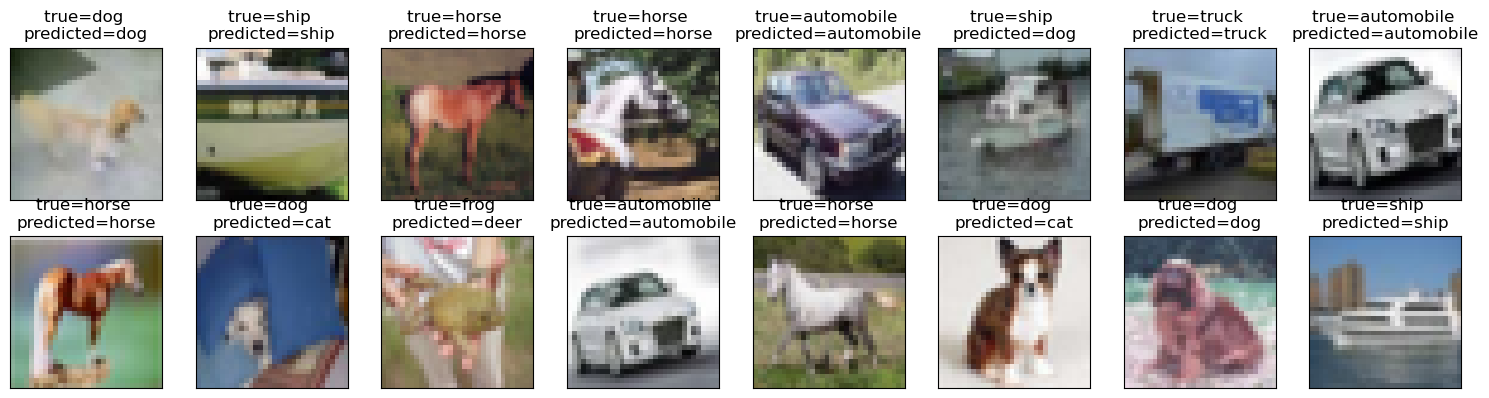

In [66]:
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
axes = axes.ravel()

# 16개의 무작위 이미지를 선택하여 표시
for i in range(16):
    idx = np.random.randint(0, len(y_test))  # 무작위 인덱스 생성
    axes[i].imshow(X_test[idx, :])      # 이미지 표시
    axes[i].set_xticks([])                    # x축 눈금 제거
    axes[i].set_yticks([])                    # y축 눈금 제거
    # 실제 라벨과 예측된 라벨로 제목 설정
    axes[i].set_title("true={} \npredicted={}".
                      format(cifa10_classes[y_true[idx]], cifa10_classes[y_pred[idx]]))

plt.tight_layout() # 서브플롯들이 겹치지 않도록 레이아웃 조정
plt.show() 

## accuracy 시각화

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm

array([[697,  10,  85,  26,  31,   6,  15,  10,  97,  23],
       [ 17, 846,  10,  14,   5,   7,  17,   5,  26,  53],
       [ 47,   4, 623,  65, 111,  46,  74,  22,   7,   1],
       [ 10,   5,  89, 590,  75, 115,  77,  25,   8,   6],
       [  9,   1,  79,  63, 696,  23,  64,  53,  12,   0],
       [  4,   2,  77, 256,  68, 528,  20,  40,   3,   2],
       [  4,   1,  42,  64,  44,   7, 834,   1,   3,   0],
       [  6,   1,  48,  51,  73,  59,   4, 753,   2,   3],
       [ 31,  27,  20,  31,  12,   4,   8,   7, 850,  10],
       [ 28,  86,  11,  46,   9,   5,  18,  26,  33, 738]], dtype=int64)

### heatmap 작성

Test Accuracy : 0.7155


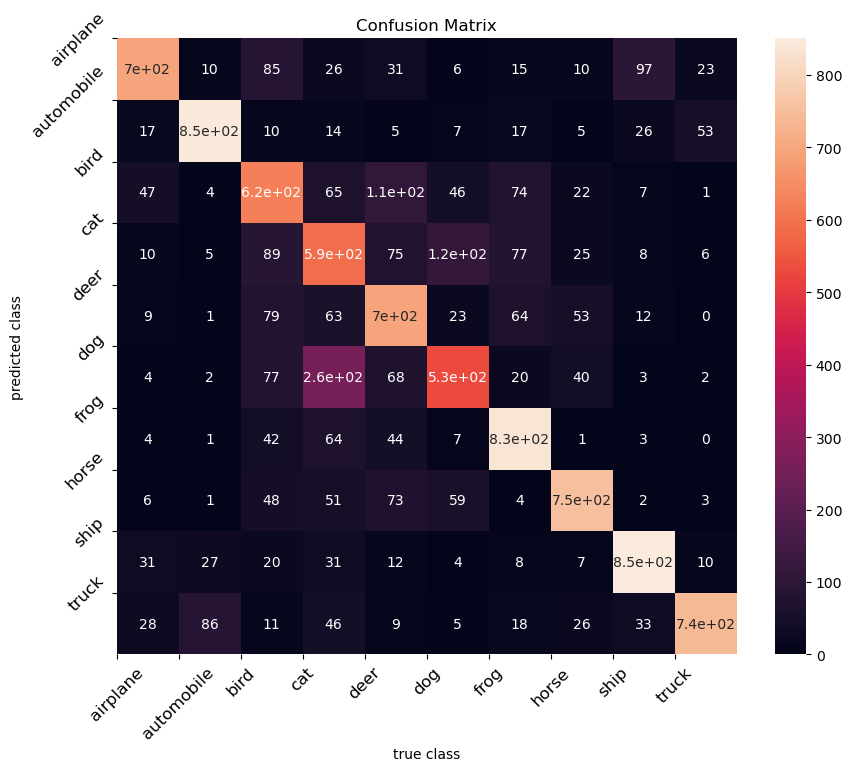

In [68]:
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True)

plt.xticks(np.arange(10), cifa10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifa10_classes, rotation=45, fontsize=12)
plt.xlabel("true class")
plt.ylabel("predicted class")
plt.title('Confusion Matrix')
print('Test Accuracy :', accuracy_score(y_true, y_pred))

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred, average='macro')

# Recall
recall = recall_score(y_true, y_pred, average='macro')

# F1-Score
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7155
Precision: 0.7257
Recall: 0.7155
F1-Score: 0.7175


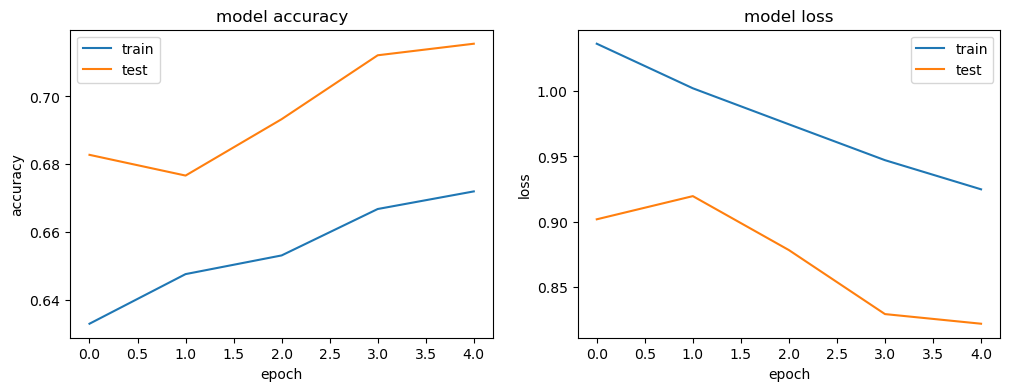

In [70]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

# 실습 :

## Convolutional Layer 와 Pooling Layer 를  추가하고 Hyper-parameter 조정하여 성능 개선 혹은 epochs 늘려서 accuracy 향상 비교

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
# model build
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) # strides 지정이 생략됨 => pool 사이즈와 동일하게
model.add(Dropout(0.3)) # 20 % 뉴런 deactivate

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten()) # Dense 레이어와 연결하기 위해
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 아웃풋 레이어와 바로 열결 / 다중분류여서 softmax

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,495,178 (9.52 MB)

 Trainable params: 2,493,194 (9.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# model compile : 다중분류여서 categorical_crossentropy
# Adam을 함수로 부르게 되면 파라미터로 학습률등을 지정 가능
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# 모델 학습
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)
model.evaluate(test_ds, verbose=0)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.3569 - loss: 1.9747 - val_accuracy: 0.3853 - val_loss: 1.6829 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5831 - loss: 1.1715 - val_accuracy: 0.5452 - val_loss: 1.3292 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6506 - loss: 0.9901 - val_accuracy: 0.6897 - val_loss: 0.8839 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6858 - loss: 0.8997 - val_accuracy: 0.5032 - val_loss: 1.5039 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7078 - loss: 0.8297 - val_accuracy: 0.6057 - val_loss: 1.1683 - learning_rate: 0.0010
Epoch 6/50
777/782 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7231 - loss: 0.7866
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7231 - loss: 0.786

[0.4667564034461975, 0.8414000272750854]

In [ ]:
# 확률 분포를 반환하므로 argmax를 이용해, 가장 확률이 높은 인덱스값 반환하도록
# => y_test와 비교할 수 있음
y_pred = model.predict(X_test_scaled).argmax(axis=-1)
# y_test를 flatten : (10000,1) => (10000,)
y_true = y_test.ravel()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


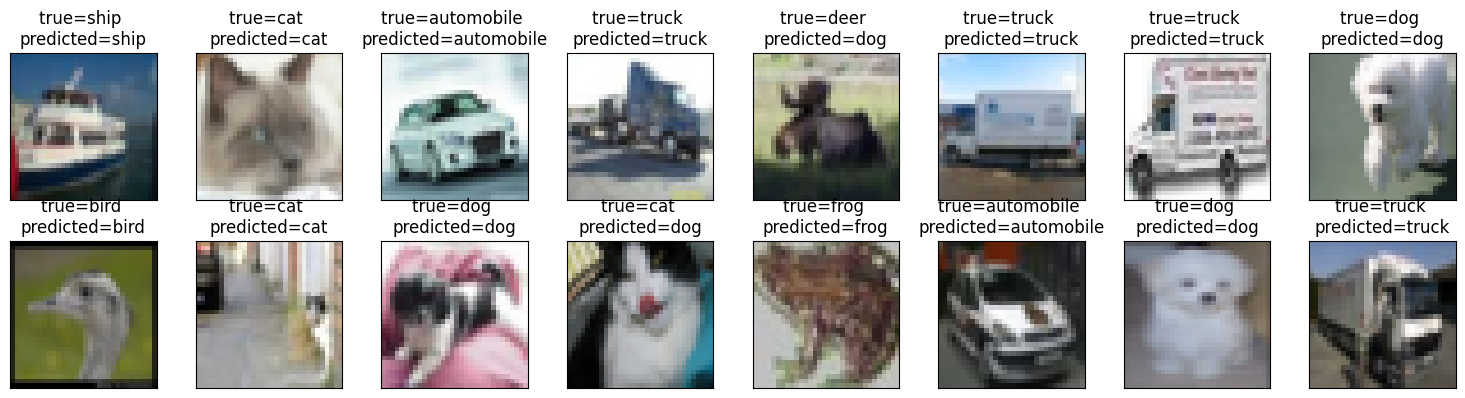

In [ ]:
fig, axes = plt.subplots(2, 8, figsize=(15, 4))
axes = axes.ravel()

# 16개의 무작위 이미지를 선택하여 표시
for i in range(16):
    idx = np.random.randint(0, len(y_test))  # 무작위 인덱스 생성
    axes[i].imshow(X_test[idx, :])      # 이미지 표시
    axes[i].set_xticks([])                    # x축 눈금 제거
    axes[i].set_yticks([])                    # y축 눈금 제거
    # 실제 라벨과 예측된 라벨로 제목 설정
    axes[i].set_title("true={} \npredicted={}".
                      format(cifa10_classes[y_true[idx]], cifa10_classes[y_pred[idx]]))

plt.tight_layout() # 서브플롯들이 겹치지 않도록 레이아웃 조정
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

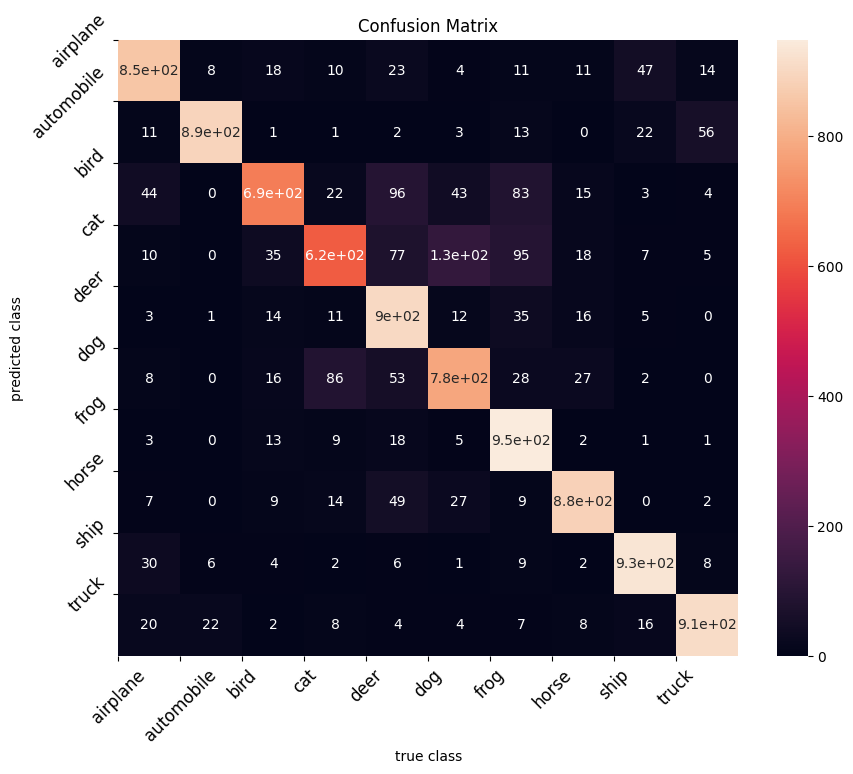

In [ ]:
## accuracy 시각화
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm
### heatmap 작성
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True)

plt.xticks(np.arange(10), cifa10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifa10_classes, rotation=45, fontsize=12)
plt.xlabel("true class")
plt.ylabel("predicted class")
plt.title('Confusion Matrix')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred, average='macro')

# Recall
recall = recall_score(y_true, y_pred, average='macro')

# F1-Score
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8414
Precision: 0.8459
Recall: 0.8414
F1-Score: 0.8397


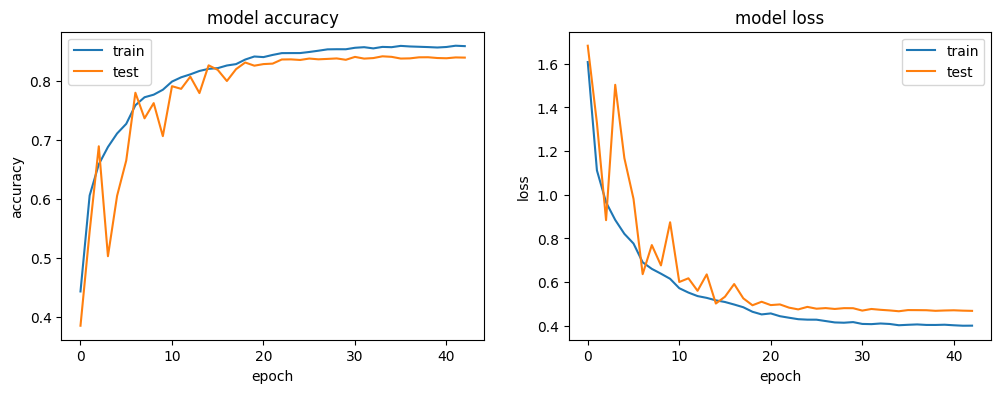

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])


# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용

In [97]:
!pip install tensorflow_hub==0.14.0

### STEP #1: IMPORT LIBRARIES

In [98]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

In [99]:
tf.__version__, hub.__version__

('2.12.0', '0.14.0')

### STEP #2: Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

- Fine Tuning 없이 사용하기 위해 Full Model download

In [109]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

Trained_MobileNet = tf.keras.Sequential([
    hub.KerasLayer(Trained_MobileNet_url, input_shape=(224, 224, 3))
])

# 모델 입력 및 출력 확인
print(Trained_MobileNet.input, Trained_MobileNet.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_1_input'), name='keras_layer_1_input', description="created by layer 'keras_layer_1_input'") KerasTensor(type_spec=TensorSpec(shape=(None, 1001), dtype=tf.float32, name=None), name='keras_layer_1/StatefulPartitionedCall:0', description="created by layer 'keras_layer_1'")


### STEP #3: PRE-TRAINED MOBILENET 평가

임의의 사진을 internet에서 가져온다

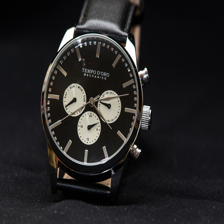

In [110]:
from PIL import Image       # 이미지 처리
from urllib import request  # 인터넷에서 가져오기 함
from io import BytesIO      # 인터넷에서 사진 수집시 아스키코드로 수집되므로 이미지형태로 바꾸기 위해

# 수집할 이미지 url로 가져옴
url = "https://github.com/ironmanciti/MachineLearningBasic/blob/master/datasets/TransferLearningData/watch.jpg?raw=true"
res = request.urlopen(url).read()
Sample_Image = Image.open(BytesIO(res)).resize((224, 224)) # 모델 입력 사이즈에 맞춰서 resize (tuple로)

Sample_Image

In [111]:
# numpy array로 샘플이미지를 넣어서 프리프로세싱된 이미지 데이터 출력
# 모델이 입력데이터를 어떻게 전처리 했는지 모르기 때문에 preprocess_input을 사용해 전처리
x = tf.keras.applications.mobilenet.preprocess_input(np.array(Sample_Image))
x.shape # (224, 224, 3)

(224, 224, 3)

In [112]:
# 클래스 예측 : 1001가지 확률 분포 (1000개의 클래스 + 배경 1개)
predicted_class = Trained_MobileNet.predict(np.expand_dims(x, axis = 0)) # 한건의 이미지지만 배치인것 처럼줌 

1/1 [==============================] - 2s 2s/step


In [113]:
# 분류된 클래스의 인덱스가 추출 -> ex) 827 : 827번째 클래스로 분류것
predicted_class.argmax(axis=-1)

array([827], dtype=int64)

In [114]:
# 해당 사진의 클래스별 예측 확률 top 5 확인 
decode_predictions(predicted_class[:, 1:])  # 첫번째 label은 background

35363/35363 [==============================] - 0s 0us/step


[[('n04328186', 'stopwatch', 9.720395),
  ('n02708093', 'analog_clock', 8.040993),
  ('n03706229', 'magnetic_compass', 6.8818045),
  ('n04548280', 'wall_clock', 6.6048026),
  ('n03075370', 'combination_lock', 4.925518)]]

In [118]:
# 1000가지 레이블이 뭐가 있는지 확인
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[:10])

['background' 'tench' 'goldfish' 'great white shark' 'tiger shark'
 'hammerhead' 'electric ray' 'stingray' 'cock' 'hen']


Text(0.5, 1.0, 'Predicted Class is: Background')

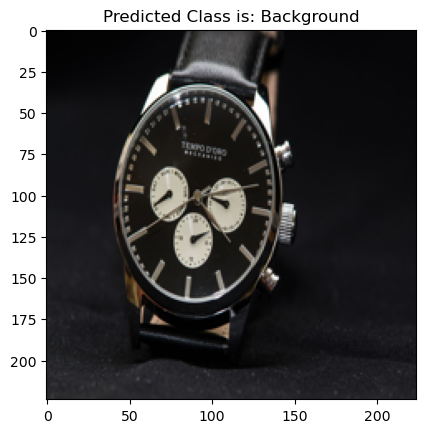

In [119]:
# 입력 사진과 분류된 것으로 제목으로 하여 시각화
plt.imshow(Sample_Image)
predicted_class = imagenet_labels[np.argmax(predicted_class)]
plt.title("Predicted Class is: " + predicted_class.title())

### STEP #4: 특정 domain 의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning

#### MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

In [120]:
# Specify path of the flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 54s 0us/step


In [121]:
# 이미지 자동 레이블링 : Found 3670 images belonging to 5 classes
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) # 전처리 모듈

flowers_data = image_generator.flow_from_directory(flowers_data_path, 
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [122]:
# input_batch : 이미지 자체
# label_batch : 이미지가 존재하는 폴더 이름
input_batch, label_batch = next(flowers_data) # 제너레이터 함수이므로 next를 이용해 데이터를 가져옴

print("Image batch shape: ", input_batch.shape)    # (64, 224, 224, 3)
print("Label batch shape: ", label_batch.shape)    # (64, 5) : 원핫인코딩 되어있음
print("Label class 수: ", flowers_data.num_classes) # 5
print("Class Index : ", flowers_data.class_indices) # {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [123]:
# Key : label 이름,  Value : index => Key : index,  Value : label 이름
# 어떤 인덱스가 어떤 레이블 명인지 확인 가능하록
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화

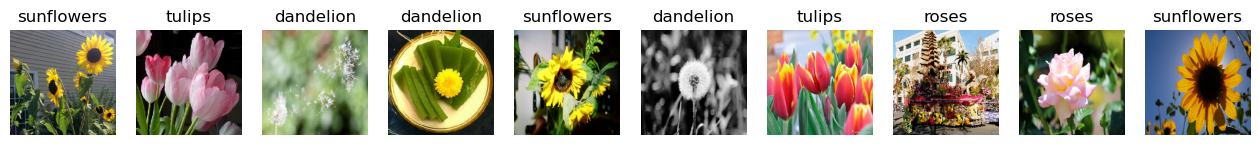

In [124]:
plt.figure(figsize=(16, 8))

for i in range(10):
    plt.subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [126]:
# 임의의 꽃 이미지 1 개를 선택하여 prediction 비교 : 성능이 안 좋다.
prediction = Trained_MobileNet.predict(input_batch[2:3])
decode_predictions(prediction[:, 1:])  

1/1 [==============================] - 0s 193ms/step


[[('n01773797', 'garden_spider', 7.5171304),
  ('n04275548', 'spider_web', 7.2834034),
  ('n03930313', 'picket_fence', 5.564491),
  ('n03388043', 'fountain', 4.1048026),
  ('n02280649', 'cabbage_butterfly', 3.9811873)]]

In [127]:
decode_predictions(prediction[:, 1:])

[[('n01773797', 'garden_spider', 7.5171304),
  ('n04275548', 'spider_web', 7.2834034),
  ('n03930313', 'picket_fence', 5.564491),
  ('n03388043', 'fountain', 4.1048026),
  ('n02280649', 'cabbage_butterfly', 3.9811873)]]

#### STEP #5: 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain

#### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [128]:
# 탑 레이어를 제거한 모델의 url
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [129]:
# 특성 피처값
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))
feature_batch = extractor_layer(input_batch)

print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [130]:
# MobileNet 의 pre-trained weight 는 update x 
# Top layer 에 Dense layer 추가
# CNN layer = 유지 / 추가한 완전연결층 (Dense Layer) = 새롭게 학습 하는 략
extractor_layer.trainable = False

In [131]:
# Build a model with two pieces:
#    (1)  MobileNet Feature Extractor
#    (2)  Dense Network (classifier) added at the end

model = tf.keras.Sequential([
  extractor_layer,
  tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_14 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [132]:
# output shape 이 정확한지 training 전에 사전 check
# (<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
# <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_2_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_14')>)

In [133]:
# 모델 컴파일 및 훈련
# 다중분류이므로 categorical_crossentropy
# 64개씩 flower data가 불러들여옴
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 271s 4s/step - loss: 0.8810 - accuracy: 0.6692
Epoch 2/30
58/58 [==============================] - 249s 4s/step - loss: 0.4618 - accuracy: 0.8436
Epoch 3/30
58/58 [==============================] - 244s 4s/step - loss: 0.3756 - accuracy: 0.8744
Epoch 4/30
58/58 [==============================] - 231s 4s/step - loss: 0.3357 - accuracy: 0.8894
Epoch 5/30
58/58 [==============================] - 194s 3s/step - loss: 0.2967 - accuracy: 0.9014
Epoch 6/30
58/58 [==============================] - 224s 4s/step - loss: 0.2700 - accuracy: 0.9147
Epoch 7/30
58/58 [==============================] - 215s 4s/step - loss: 0.2452 - accuracy: 0.9232
Epoch 8/30
58/58 [==============================] - 227s 4s/step - loss: 0.2325 - accuracy: 0.9281
Epoch 9/30
58/58 [==============================] - 251s 4s/step - loss: 0.2141 - accuracy: 0.9365
Epoch 10/30
58/58 [==============================] - 227s 4s/step - loss: 0.2026 - accuracy: 0.9401
Epoch 11/

### STEP #6: Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [134]:
# 확률 분포로 나옴
y_pred = model.predict(input_batch)
# 분류된 것의 인덱스를 가지도록
y_pred = np.argmax(y_pred, axis=-1)
# 정답 데이터의 인덱스 확인
y_true = np.argmax(label_batch, axis=-1)

2/2 [==============================] - 5s 2s/step


In [135]:
# 정확도
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'98.44 %'

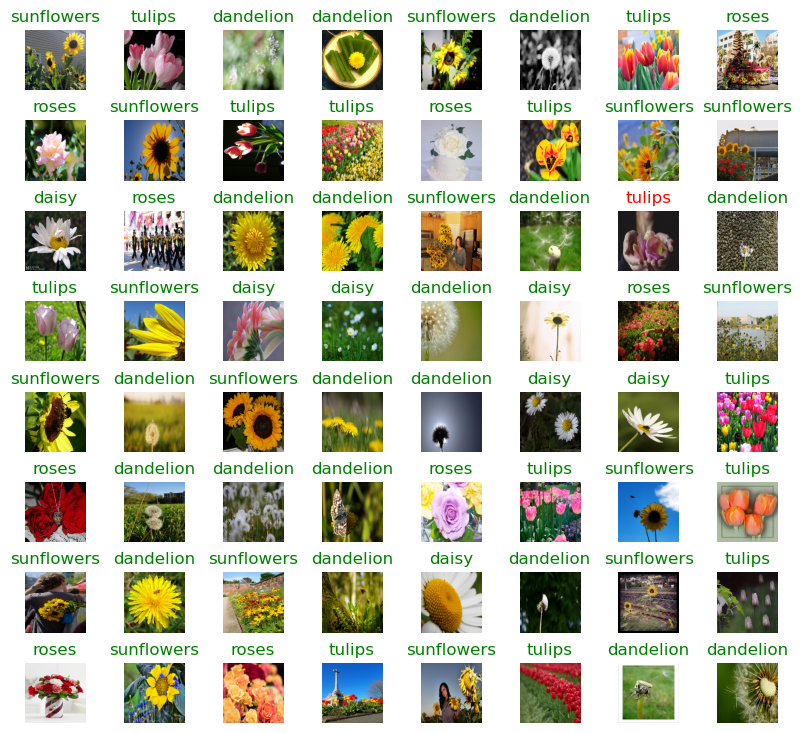

In [136]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for i in range(64):
  plt.subplot(8, 8, i+1)
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)
  plt.imshow(img)
  color = "green" if y_pred[i] == y_true[i] else "red"
  plt.title(class_names[y_pred[i]], color=color)
  plt.axis('off')
